In [1]:
import numpy as np
import pandas as pd
import datetime
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Load the data

In [2]:
import pandas as pd
df = pd.read_csv('C:/Users/User/Documents/le wagon project/coronanet_release_allvars.csv', encoding='mac_roman')

In [3]:
def tristans_columns(df):
        df = df.copy()
        # df['date_announced'] = pd.to_datetime(df['date_announced'])
        df['date_start'] = pd.to_datetime(df['date_start'])
       # df['date_end'] = pd.to_datetime(df['date_end'])
       #  df['date_announced'].fillna(df['date_start'], inplace = True)
       # df['date_start'].clip(lower=df['date_announced'], inplace=True)
        df_select = df[['policy_id', 'date_start', 'country',
           'type', 'type_sub_cat','description', 'ISO_A3','compliance']]
        return df_select

In [4]:
df= tristans_columns(df)

In [5]:
df = df.dropna().reset_index()

# Preprocessing

In [6]:
#Create a new column with the data I need
df["type_and_description"] = df["type"]+' '+df["description"]

In [7]:
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 

# This function does all the NLP dirty work
def clean (text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

In [8]:
df['clean_description'] = df.type_and_description.apply(clean)

# Filtering out inconsistent descriptions

Some descriptions are waaaaaay too long, these bugs need to be fixed (tha hard way)

In [9]:
df["type_and_description_tokenized"] = df["type_and_description"].apply(clean)
df["type_and_description_tokenized"].head(3)

0    [closure, regulation, school, school, herat, ñ...
1    [closure, regulation, school, school, herat, ñ...
2    [closure, regulation, school, school, herat, ñ...
Name: type_and_description_tokenized, dtype: object

In [10]:
df["longueur_blabla"] = [len(_) for _ in df["type_and_description_tokenized"]]
df_filtered = df.copy().query("longueur_blabla < = 80")

In [11]:
df_filtered.shape

(30088, 13)

<AxesSubplot:xlabel='longueur_blabla', ylabel='Density'>

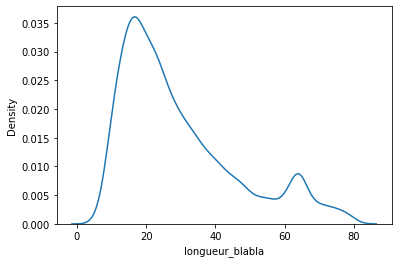

In [12]:
sns.kdeplot(df_filtered["longueur_blabla"])

In [13]:
max(df_filtered["longueur_blabla"])

80

# OK now lets encode our sub-cats

In [14]:
#Shape to match (keep in mind for later)
X = df_filtered['clean_description']
X.shape

(30088,)

In [15]:
#a simple label encoder seems to work ?
from sklearn import preprocessing
y = df_filtered['type_sub_cat']
labelenc = preprocessing.LabelEncoder()
y_encoded = labelenc.fit_transform(y)
y_encoded

array([64, 65, 86, ..., 62, 55,  3])

In [16]:
#now I have to set it to categorical values (not sure why)
from keras.utils import to_categorical

y_cat = to_categorical(y_encoded)
y_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
labelenc_target = dict(zip(y, y_encoded))

# Now we can split (and check the shape)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20158,), (9930,), (20158,), (9930,))

# Lets create our dictionnary

In [20]:
def create_dictionnary(X_train):
    word_to_id = {}
    iter_ = 1
    for sentence in X_train:
        for word in sentence:
            if word in word_to_id:
                continue
            word_to_id[word] = iter_
            iter_ += 1
    return word_to_id

In [21]:
#This dict will categorize EACH word 
vocab_train_word_to_id = create_dictionnary(X_train)

# Tokenization to numbers

In [22]:
def tokens_word_to_id(sentences,word_to_id):
    return [[word_to_id[word] for word in sentence if word in word_to_id] for sentence in sentences]

In [23]:
X_train_tokenized = tokens_word_to_id(X_train,vocab_train_word_to_id)
X_test_tokenized = tokens_word_to_id(X_test,vocab_train_word_to_id)

In [24]:
X[0]

['closure',
 'regulation',
 'school',
 'school',
 'herat',
 'ñ',
 'including',
 'temporarily',
 'learning',
 'space',
 'tl',
 'community',
 'based',
 'education',
 'cbe',
 'ñ',
 'suspended',
 'notice',
 'help',
 'contain',
 'spread',
 'covid',
 'although',
 'public',
 'school',
 'university',
 'currently',
 'closed',
 'winter',
 'break',
 'expected',
 'resume',
 'march']

In [25]:
X_train_tokenized[0]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 3,
 10,
 3,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

# Last but not least : THE PADDING !

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_tokenized, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_tokenized, dtype='float32', padding='post')

In [27]:
X_train_pad.shape

(20158, 80)

In [28]:
X_test_pad.shape

(9930, 80)

# And now : the DL NLP model !

In [77]:
from tensorflow.keras import Sequential, layers

def init_model(vocab_length):
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_length+1, output_dim=30))
    model.add(layers.LSTM(10))
    model.add(Conv1D(10,  kernel_size=(3), padding='same',input_shape=(vocab_length, 1),ndim=3))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(layers.Dense(1, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [78]:
vocab_length = len(vocab_train_word_to_id)
vocab_length

15397

In [79]:
model = init_model(vocab_length)

TypeError: ('Keyword argument not understood:', 'ndim')

In [ ]:
model.summary()

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, 
          epochs=10, 
          batch_size=32,
          validation_data= [X_test_pad,y_test] ,
          callbacks=[es],
          verbose=1
         )


Epoch 1/10
630/630 [==============================] - 24s 38ms/step - loss: 0.0000e+00 - accuracy: 0.0167 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
630/630 [==============================] - 24s 38ms/step - loss: 0.0000e+00 - accuracy: 0.0167 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
630/630 [==============================] - 23s 36ms/step - loss: 0.0000e+00 - accuracy: 0.0167 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
630/630 [==============================] - 25s 40ms/step - loss: 0.0000e+00 - accuracy: 0.0167 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
